This notebook uses data.x2 (69 features) to do individual sphase prediction.

In [7]:
import data1 as data
import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.colors as mcolors


In [8]:
import warnings
warnings.filterwarnings("ignore")

## Individual phase prediction


In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 1, 2])
lr_pcc = ProbabilisticClassifierChain(lr) 

# gams not fixed, remove this part.
# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=20.0, max_iter=250))
# gam_chain = ClassifierChain(LogisticGAM(lam=20.0, max_iter=250))
# gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=20.0, max_iter=250)) 

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1])
rf_pcc = ProbabilisticClassifierChain(rf)

# Rulefit
rufit = RuleFitWrapper()

indi_estimators = [lr, rf, rufit]
indi_names = ['LR', 'RanF', 'RuFit']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result.

In [10]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

inter_no_comp = {}

for y in [data.sphere, data.vesicle, data.worm, data.other]: # miss other
    print('Target: ',y.name)
    experiment = Experiment(indi_estimators, 
                        indi_names,
                        KFold(30, shuffle=True, random_state=STATE),
                        data.x2, y.replace(-1, 0),
                        groups=data.comp_ids.array, 
                        evaluators=['accuracy', LogLikelihoodEvaluator()],
                        verbose=True)
    inter_no_comp[y.name] = experiment.run()
    print()

Target:  sphere
Running experiment with 30 repetitions
******************************

Target:  vesicle
Running experiment with 30 repetitions
******************************

Target:  worm
Running experiment with 30 repetitions
******************************

Target:  other
Running experiment with 30 repetitions
******************************



In [12]:
def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)
    
for key in inter_no_comp:
    df = inter_no_comp[key].summary()
    df['mean_train_error'] = 1- df['mean_train_accuracy']
    df['std_train_error'] = df['std_train_accuracy']
    df['mean_test_error'] = 1- df['mean_test_accuracy']
    df['std_test_error'] = df['std_test_accuracy']
    inter_no_comp[key] = df

In [26]:
# get base line 
# error
informed_error = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_error.append((1-max(prob)))
print('Informed error: ', informed_error)

uniformed_error = [0.5, 0.5, 0.5, 0.5]
print('Uninformed error: ', uniformed_error)

Informed error:  [0.46283783783783783, 0.2922297297297297, 0.33783783783783783, 0.02533783783783783]
Uninformed error:  [0.5, 0.5, 0.5, 0.5]


In [16]:
inter_no_comp['sphere']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.537162,0.004921,0.537193,0.142011,-0.680825,0.001401,-0.685333,0.041018,0.462838,0.004921,0.462807,0.142011
RF,1.000000,0.000000,0.912544,0.073394,-0.056800,0.001796,-0.283283,0.350926,0.000000,0.000000,0.087456,0.073394
RuFit,0.984331,0.004017,0.920877,0.059965,-0.076602,0.003566,-0.254798,0.178673,0.015669,0.004017,0.079123,0.059965


In [17]:
inter_no_comp['vesicle']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.70777,0.003560,0.707544,0.103307,-0.596987,0.003042,-0.599935,0.088084,0.29223,0.003560,0.292456,0.103307
RF,1.00000,0.000000,0.925526,0.059458,-0.049419,0.001104,-0.188003,0.088390,0.00000,0.000000,0.074474,0.059458
RuFit,0.98870,0.003665,0.910614,0.054427,-0.064196,0.003383,-0.200971,0.095690,0.01130,0.003665,0.089386,0.054427


In [19]:
inter_no_comp['worm']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.633911,0.009928,0.630263,0.106332,-0.580561,0.002775,-0.583295,0.079707,0.366089,0.009928,0.369737,0.106332
RF,1.000000,0.000000,0.917281,0.056844,-0.053729,0.001619,-0.253760,0.336384,0.000000,0.000000,0.082719,0.056844
RuFit,0.988525,0.002964,0.903421,0.057589,-0.071945,0.003157,-0.239482,0.118132,0.011475,0.002964,0.096579,0.057589


In [20]:
inter_no_comp['other']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.974662,0.001276,0.974737,0.036749,-0.157774,0.005536,-0.162524,0.166690,0.025338,0.001276,0.025263,0.036749
RF,1.000000,0.000000,0.981579,0.030844,-0.010783,0.000781,-0.150334,0.456164,0.000000,0.000000,0.018421,0.030844
RuFit,0.995748,0.001092,0.976491,0.038934,-0.022098,0.001853,-0.072533,0.110690,0.004252,0.001092,0.023509,0.038934


sphere 



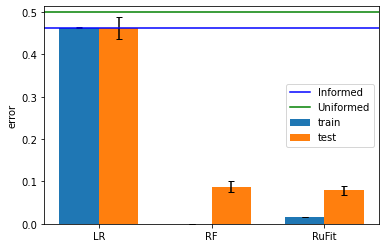

vesicle 



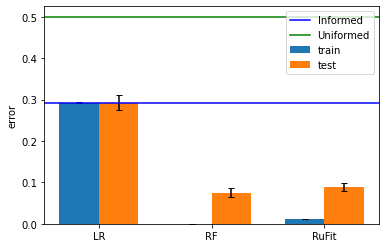

worm 



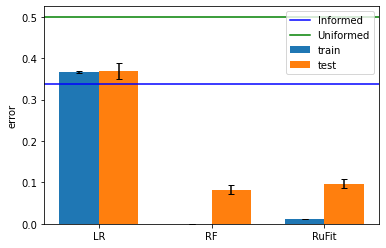

other 



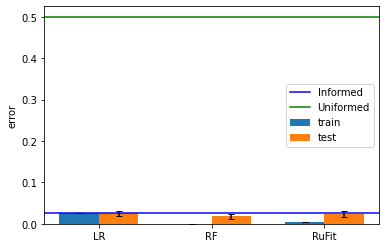

In [27]:
i = 0
for key in inter_no_comp:
    print(key, '\n')
    line = [informed_error[i], uniformed_error[i]]
    plot_summary('error', summ=inter_no_comp[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()

__Log likelihood__

All the estimators performs much better than random guessing and informed guessing.

In [29]:
# get base line 
# log loss
informed_loglikelihood = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_loglikelihood.append(sum(1*prob * np.log2(prob)))
print('Informed loglikelihood: ', informed_loglikelihood)

uniformed_loglikelihood = [1*0.5 * np.log2(0.5)*2] * 4
print('Uninformed loglikelihood: ', uniformed_loglikelihood)

Informed loglikelihood:  [-0.9960115235485287, -0.8715841441742509, -0.9227346209530941, -0.17044317741514714]
Uninformed loglikelihood:  [-1.0, -1.0, -1.0, -1.0]


sphere 



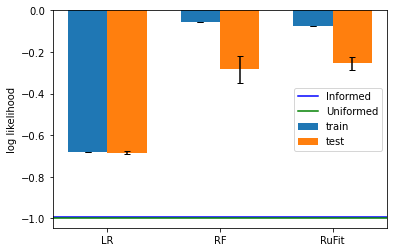

vesicle 



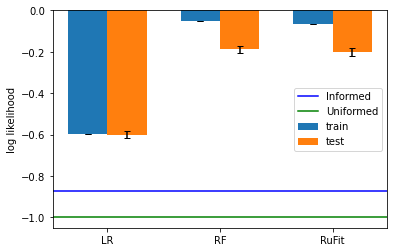

worm 



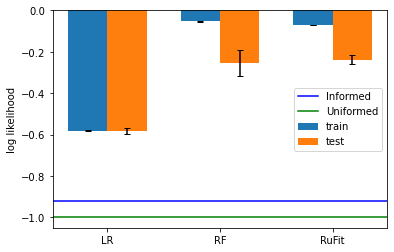

other 



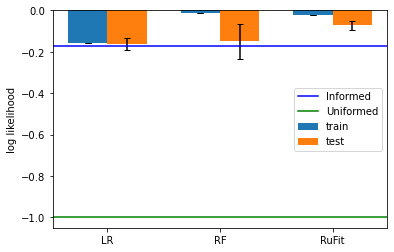

In [30]:
i = 0
for key in inter_no_comp:
    print(key, '\n')
    line = [informed_loglikelihood[i], uniformed_loglikelihood[i]]
    plot_summary('log likelihood', summ=inter_no_comp[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()

In [31]:
def loss(y_test, y_pred):
    y_test = y_test.astype(np.float16)
    y_pred = y_pred.astype(np.float16)
    if len(y_test.shape) == 1:
        N = y_test.shape[0]
        loss = 0
        for i in range(N):
            loss -= ((y_test[i]*np.log(y_pred[i]))+((1.0-y_test[i])*np.log(1.0-y_pred[i])))
            loss = loss/N
    else:
        N,M = y_test.shape
        a=[]
        for m in range(M):
            loss=0
            for i in range(N):
                subloss = ((y_test[i,m]*np.log(y_pred[i,m]))+((1.0-y_test[i,m])*np.log(1.0-y_pred[i,m])))
                if np.isnan(subloss):
                    continue
                loss -= subloss
            loss = loss/N
            a.append(round(loss,8))
        loss = np.mean(a)
    return loss

In [ ]:
# choose the best RuleFit
lst = []
for each in inter_no_comp.fitted_['rufit_pcc']:
    pred = each.predict_proba(data.x)
    res = log_loss(data.y.values, pred)
    lst.append((res, each))
lst.sort()
best_rf = lst[0][1]

In [ ]:
dic = best_rf.get_rules(data.x, data.y)
indx = -1
for key, values in dic.items():
    indx += 1
    name = 'Rules/Individual_Phase/Interpolation/'+ str(indx) + "_" + key + '.csv'
    values.to_csv(name, index=False)